In [5]:
import math

def decomp(number):
    '''
    decomp(number)
    
    decomp() breaks a number up into its significand and base-10 exponent, as it would be 
    displayed in scientific notation.
    
    ex. decomp(1024) => 1.024, 3
    '''
    
    if number == 0:
        significand = 0
        exponent = 0
    else:    
        logarithm = math.log10(abs(number))
        mantissa, exponent = math.modf(logarithm)
        if logarithm < 0:
            mantissa += 1
            exponent -= 1
        significand = math.copysign(math.pow(10, mantissa),number)
    return significand, int(exponent)


def sigfigs(number, sig_figs=8):
    '''
    sigfigs(number, sig_figs=8)
    
    sigfigs() returns a number rounded to a specified number of significant figures. Default 
    number of significant figures is 8.
    
    This can be useful when dealing with the results of floating point operations.
    
    ex. sigfigs(0.500000000001) => 0.5
    '''
    if number == 0:
        return 0
    exponent = math.floor(math.log10(abs(number)))
    decimal_places = sig_figs - exponent - 1
    return eval(('{:.'+str(decimal_places)+'f}').format(number))


def ticks(data_points, padding=0.0, steps_constraint=+5, preferred_number_series=[1,2,5], ticks_at_edge=True):
    '''
    ticks(data_points, padding=0.1, steps_constraint=+5, preferred_number_series=[1,2,5],
          ticks_at_edge=True)

    ticks() takes a list of values and returns optimal tick values as a list of floats.
    This is useful when plotting values on a graph or chart.

    It takes the following arguments:
        data_points : A list of numbers. If data_points has length 0, ticks() returns
            [0]. If data_points has length 1, ticks() returns data_points.

        padding : A list of one or two numbers, a tuple of one or two numbers, or a 
            single number. If padding has length 2, the index 0 value is used for the
            lower padding, and the index 1 value is used for the higher padding. If
            padding has length 1, or is just a number, the one value is used for both
            the lower padding and the higher padding. Default value is 0.1.

            ex. For a dataset ranging from 100 to 200 with lower padding = 0.1 and 
            higher padding = 0.3, the padded range used would be 90 to 230.

        steps_constraint : A nonzero integer. If positive, specifies the lower bound on 
            number of tickmarks. If negative, specifies the upper bound on number of 
            tickmarks. Default value is +5.

            ex. +5 for 5 or more tickmarks
            ex. -10 for 10 or fewer tickmarks

        preferred_number_series : A list of floats or integers. The series of possible 
            significands to be used as the spacing between tickmarks. Must not span
            more than a single decade. Default value is [1, 2, 5].

        ticks_at_edge : Boolean. If true, sets tickmarks at top and bottom edges of plot,
            with some outside of padded range. If false, plot edges are assumed to be at
            extremes of padded range, with all tickmarks inside padded range. Default
            value is true.
                
    '''

    if len(data_points) == 0:
        return [0]

    if len(data_points) == 1:
        return data_points

    if (type(padding) == type(tuple())) | (type(padding) == type(list())): # test if padding is a tuple or a list
        if len(padding) == 2:
            low_padding = padding[0]
            high_padding = padding[1]
        elif len(padding) == 1:
            low_padding = padding[0]
            high_padding = padding[0]
        else:
            raise Exception('Error with padding parameter length.',padding)
    elif (type(padding) == type(int())) | (type(padding) == type(float())): # test if padding is an int or a float
        low_padding = padding
        high_padding = padding
    else:
        raise Exception('Error with padding parameter type.',padding)
    
    if (steps_constraint == 0) | (steps_constraint != int(steps_constraint)):
        raise Exception('Error: steps_constraint must be a non-zero integer.',steps_constraint)
    
    if (max(preferred_number_series)/min(preferred_number_series)) > 10:
        raise Exception('Error: preferred_number_series must span less than one decade.',preferred_number_series)
    
    data_high = max(data_points)
    data_low = min(data_points)
    data_range = data_high - data_low

    padded_low = data_low - (data_range*low_padding)
    padded_high = data_high + (data_range*high_padding)
    padded_range = padded_high - padded_low

    step_size_at_constraint = padded_range/abs(steps_constraint)

    con_step_size_sig, step_size_exp = decomp(step_size_at_constraint)

    poss_step_sizes = []

    if steps_constraint > 0:
        # See where the significand of the max step size falls in the preferred numbers list
        # being the MAX step size, take any preferred numbers that are greater and divide them by ten
        for preferred_number in preferred_number_series:
            if math.isclose(preferred_number, con_step_size_sig, rel_tol=1e-08, abs_tol=0.0): # test for equality
                poss_step_sizes.append(preferred_number)
            elif preferred_number < con_step_size_sig: # test if preferred number is less
                poss_step_sizes.append(preferred_number)
            else:
                poss_step_sizes.append(preferred_number/10) # otherwise adjust so that it IS less
        poss_step_sizes.sort(reverse=False) # sort for the following poss_step_sizes loop
        
        # see how many steps each possible step size would give
        best_steps_so_far = float('Inf')
        for poss_step_size_sig in poss_step_sizes:
            step_size = poss_step_size_sig * 10**step_size_exp
            num_steps = int(padded_range / step_size)
            if (num_steps >= abs(steps_constraint)) & (num_steps < best_steps_so_far):
                best_steps_so_far = num_steps
                best_step_size_so_far = step_size

    if steps_constraint < 0:
        # See where the significand of the min step size falls in the preferred numbers list
        # being the MIN step size, take any preferred numbers that are less and multiply them by ten
        for preferred_number in preferred_number_series:
            if math.isclose(preferred_number, con_step_size_sig, rel_tol=1e-08, abs_tol=0.0): # test for equality
                poss_step_sizes.append(preferred_number)
            elif preferred_number > con_step_size_sig: # test if preferred number is greater
                poss_step_sizes.append(preferred_number)
            else:
                poss_step_sizes.append(preferred_number*10) # otherwise adjust so that it IS greater
        poss_step_sizes.sort(reverse=True) # sort for the following poss_step_sizes loop

        # see how many steps each possible step size would give
        best_steps_so_far = 0
        for poss_step_size_sig in poss_step_sizes:
            step_size = poss_step_size_sig * 10**step_size_exp
            num_steps = int(padded_range / step_size)
            if (num_steps <= abs(steps_constraint)) & (num_steps > best_steps_so_far):
                best_steps_so_far = num_steps
                best_step_size_so_far = step_size        

    num_steps = best_steps_so_far
    step_size = best_step_size_so_far

    # building tick list
    mult = 0
    ticklist = []
    
    if ticks_at_edge == True:
        bottom_tick = math.floor(padded_low/step_size)*step_size
        top_tick = math.ceil(padded_high/step_size)*step_size
    else:
        bottom_tick = math.ceil(padded_low/step_size)*step_size
        top_tick = math.floor(padded_high/step_size)*step_size

    # Use sigfigs function to avoid the perils of floating point operations!
    while sigfigs(bottom_tick + mult*step_size) < sigfigs(top_tick):
        ticklist.append(sigfigs(bottom_tick + mult*step_size))
        mult += 1
    ticklist.append(sigfigs(top_tick))

    return ticklist

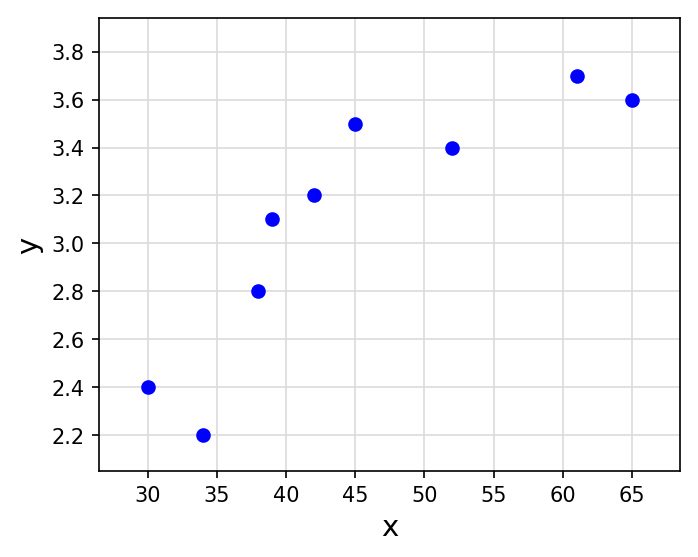

In [6]:
import matplotlib.pyplot as plt

x = [42, 38, 61, 34, 30, 65, 52, 45, 39]
y = [3.2, 2.8, 3.7, 2.2, 2.4, 3.6, 3.4, 3.5, 3.1]

xhi = max(x)
xlo = min(x)
yhi = max(y)
ylo = min(y)
xrng = xhi - xlo
yrng = yhi - ylo
xpadhi = 0.1
xpadlo = 0.1
ypadhi = 0.16
ypadlo = 0.1

plt.figure(num=0, figsize=(5, 4), dpi=150, facecolor='w', edgecolor='k')
plt.grid(b=True, which='major', axis='both', color='gainsboro', zorder=0.0)
plt.plot(x,y,'bo',zorder=2.4)
plt.xlabel("x",color="black",fontdict={'size': 14})
plt.ylabel("y",color="black",fontdict={'size': 14})
plt.xticks(ticks=ticks(x,padding=0.0))
plt.yticks(ticks=ticks(y,padding=0.0))
plt.xlim([xlo - xpadlo*xrng, xhi + xpadhi*xrng])
plt.ylim([ylo - ypadlo*yrng, yhi + ypadhi*yrng])

plt.show()